# 추천 시스템 개요

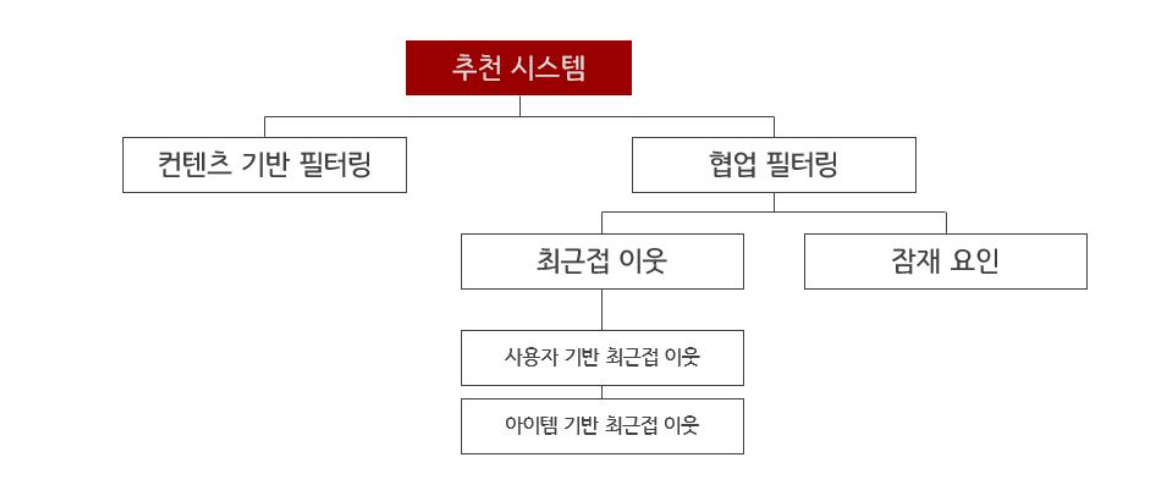

이미지 출처 : https://greeksharifa.github.io/machine_learning/2019/12/17/Recommendation-System/
<br>
<br>

### 콘텐츠 기반 필터링 
<br>
콘텐츠(아이템)가 가지고 있는 특징들을 바탕으로 추천

- ex. 이를테면 영화 콘텐츠의 장르, 감독, 배우, 줄거리 등을 파악해 이와 유사한 다른 영화를 추천하는 방식

<br>
<br>

### 협업 필터링 : 
<br>
사용자가 남긴 행동 양식(별점, 구매 이력) 등을 바탕으로 추천
 
    1. 최근접 이웃 ; 사용자-아이템 행렬에 의존해 빈 칸을 채워나가는 방식
    
    사용자 기반 최근접 이웃 : 
        특정 사용자의 행동 양식과 비슷한 사용자를 찾고 해당 데이터를 바탕으로 추천.
    
    아이템 기반 최근접 이웃 :
        사용자가 선호하는 특정 아이템과 유사한 아이템을 찾아 추천.
        -ex. 별점 내역, 구매 패턴
    
    2. 잠재 요인 ; 사용자-아이템 행렬에 숨어 있는 잠재 요인을 찾아낸다.
    
    행렬 분해를 통해 행동 양식에 숨어 있는 잠재 요인(ex. 장르, 배우 등)을 구하고 이를 바탕으로 빈 칸을 모두 채운 뒤 추천.

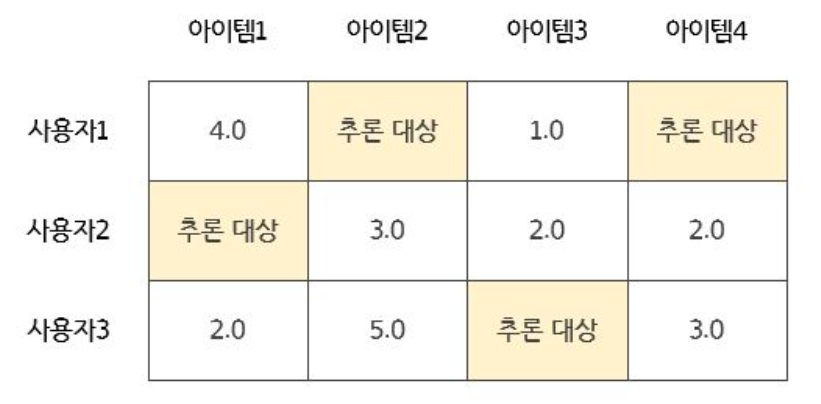
사용자-아이템 행렬과 추론 대상. 이미지 출처 : https://greeksharifa.github.io/machine_learning/2019/12/17/Recommendation-System/

<br>
<br>
<br>

# 1. 콘텐츠 기반 추천

## 1) 장르 추천

In [1]:
import os
import pandas as pd
import numpy as np

from ast import literal_eval

from tqdm import tqdm
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
#각자 경로에 맞게 조정
path = '../Final-project/data/'

ratings_df = pd.read_csv(os.path.join(path,'ratings.csv'), encoding='utf-8')
movies_df = pd.read_csv(os.path.join(path, 'result_movie.csv'), index_col = 'movieId', encoding='utf-8')

In [3]:
movies_df.head()

,title_en,title_ko,genres,year,vote_average,vote_count,director,actor,poster,link
movieId,,,,,,,,,,
1,Toy Story (1995),토이 스토리,Adventure|Animation|Children|Comedy|Fantasy,1995,7.7,5415.0,존 라세터,"['톰 행크스', '팀 알렌']",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
2,Jumanji (1995),쥬만지,Adventure|Children|Fantasy,1995,6.9,2413.0,조 존스톤,"['로빈 윌리엄스', '커스틴 던스트', '데이빗 알란 그리어', '아담 한 바이어...",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
3,Grumpier Old Men (1995),그럼피어 올드 맨,Comedy|Romance,1995,6.5,92.0,하워드 도이치,"['월터 매튜', '잭 레먼', '앤 마그렛']",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
4,Waiting to Exhale (1995),사랑을 기다리며,Comedy|Drama|Romance,1995,6.1,34.0,포레스트 휘태커,"['휘트니 휴스턴', '안젤라 바셋', '로레타 드바인']",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
5,Father of the Bride Part II (1995),신부의 아버지 2,Comedy,1995,5.7,173.0,찰스 샤이어,"['스티브 마틴', '다이안 키튼', '마틴 숏']",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...


#### 장르 분석

In [4]:
#장르 추출
total_count = len(movies_df)
total_genres = set(sum(list(map(lambda x : x.split('|'),movies_df['genres'])),[]))
total_genres = list(total_genres)
total_genres

['Thriller',
 'IMAX',
 'Film-Noir',
 'Romance',
 'Adventure',
 'Comedy',
 'Horror',
 'Action',
 'Documentary',
 'Drama',
 'Children',
 'Animation',
 'Mystery',
 'Fantasy',
 'Musical',
 'Western',
 '(no genres listed)',
 'War',
 'Crime',
 'Sci-Fi']

In [5]:
#장르별 갯수 파악
genre_count = Counter(sum(list(map(lambda x : x.split('|'),movies_df['genres'])),[]))
genre_count

Counter({'Adventure': 932,
         'Animation': 361,
         'Children': 507,
         'Comedy': 2819,
         'Fantasy': 582,
         'Romance': 1264,
         'Drama': 3403,
         'Action': 1331,
         'Crime': 904,
         'Thriller': 1501,
         'Horror': 722,
         'Mystery': 433,
         'Sci-Fi': 701,
         'War': 283,
         'Musical': 273,
         'IMAX': 122,
         'Western': 131,
         'Film-Noir': 78,
         'Documentary': 272,
         '(no genres listed)': 13})

<br>
장르별 숫자 차이가 유의미하다. 
<br>
자주 나오는 장르보다 자주 등장하지 않는 장르가 영화를 더 잘 설명해준다고 판단 => 가중치 부여
<br><br>

## 1 - 1 ) 평점 상위 영화 25% 대상(tf-idf)

#### 추천을 위한 데이터 전처리

In [6]:
# 데이터프레임에서 장르명 추출
movies_df['genres'] = movies_df['genres'].map(lambda x : ' '.join(x.split('|')))

In [7]:
# 일정 vote_count를 충족하는 상위 25% 영화(1700편)만 추출.
cutline_count = movies_df['vote_count'].quantile(0.75)
cut_movies = movies_df.copy().loc[movies_df['vote_count'] >= cutline_count]
cut_movies.shape

(1700, 10)

In [8]:
# 추출한 새로운 데이터프레임
cut_movies.sort_values('vote_average', ascending=False)[:50]

,title_en,title_ko,genres,year,vote_average,vote_count,director,actor,poster,link
movieId,,,,,,,,,,
318,The Shawshank Redemption (1994),쇼생크 탈출,Crime Drama,1994,8.5,8358.0,프랭크 다라본트,"['팀 로빈스', '모건 프리먼']",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
163134,Your Name. (2016),너의 이름은.,Animation Drama Fantasy Romance,2016,8.5,1030.0,신카이 마코토,"['카미키 류노스케', '카미시라이시 모네']",https://ssl.pstatic.net/imgmovie/mdi/mit110/15...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
1219,Psycho (1960),싸이코,Crime Horror,1960,8.3,2405.0,알프레드 히치콕,"['안소니 퍼킨스', '베라 마일즈', '존 게빈']",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
58559,The Dark Knight (2008),다크 나이트,Action Crime Drama IMAX,2008,8.3,12269.0,크리스토퍼 놀란,"['크리스찬 베일', '히스 레저', '아론 에크하트']",https://ssl.pstatic.net/imgmovie/mdi/mit110/06...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
2324,Life Is Beautiful (1997),인생은 아름다워,Comedy Drama Romance War,1997,8.3,3643.0,로베르토 베니니,"['로베르토 베니니', '니콜레타 브라스키']",https://ssl.pstatic.net/imgmovie/mdi/mit110/02...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
296,Pulp Fiction (1994),펄프 픽션,Comedy Crime Drama Thriller,1994,8.3,8670.0,쿠엔틴 타란티노,"['존 트라볼타', '사무엘 L. 잭슨', '우마 서먼', '하비 케이틀', '팀 ...",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
527,Schindler's List (1993),쉰들러 리스트,Drama War,1993,8.3,4436.0,스티븐 스필버그,['리암 니슨'],https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
1193,One Flew Over the Cuckoo's Nest (1975),뻐꾸기 둥지 위로 날아간 새,Drama,1975,8.3,3001.0,밀로스 포만,['잭 니콜슨'],https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
112552,Whiplash (2014),위플래쉬,Drama,2014,8.3,4376.0,데이미언 셔젤,"['마일즈 텔러', 'J.K. 시몬스']",https://ssl.pstatic.net/imgmovie/mdi/mit110/11...,https://movie.naver.com/movie/bi/mi/basic.nhn?...


In [9]:
# cut_movies.to_csv('movies_1700.csv', encoding='utf-8')

#### tfidf-vectorize

In [10]:
# tf-idf ; 단어 등장 빈도에 따라 가중치를 부여한 뒤 벡터화를 진행
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

In [11]:
genres_vector = vectorizer.fit_transform(cut_movies['genres'])
genres_vector

<1700x24 sparse matrix of type '<class 'numpy.float64'>'
	with 5074 stored elements in Compressed Sparse Row format>

#### cosine_similarity

In [12]:
#코사인 유사도 분석 : 벡터 형태 데이터들의 각도를 바탕으로 유사도를 비교
from sklearn.metrics.pairwise import cosine_similarity

genres_sim = cosine_similarity(genres_vector, genres_vector)
genres_sim

array([[1.        , 0.78421987, 0.        , ..., 0.17803836, 0.        ,
        0.17666086],
       [0.78421987, 1.        , 0.        , ..., 0.22702607, 0.        ,
        0.22526955],
       [0.        , 0.        , 1.        , ..., 0.21050851, 0.51450448,
        0.        ],
       ...,
       [0.17803836, 0.22702607, 0.21050851, ..., 1.        , 0.        ,
        0.39627134],
       [0.        , 0.        , 0.51450448, ..., 0.        , 1.        ,
        0.        ],
       [0.17666086, 0.22526955, 0.        , ..., 0.39627134, 0.        ,
        1.        ]])

In [13]:
genres_sim_df = pd.DataFrame(data=genres_sim, index=cut_movies.index, columns = cut_movies.index)
genres_sim_df.head()

movieId,1,2,6,10,16,18,19,32,34,39,...,170813,170827,170957,171763,171765,172547,173145,173291,173941,175197
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.784220,0.000000,0.235947,0.000000,0.318938,0.318938,0.000000,0.440527,0.188407,...,0.221631,0.393879,0.725966,0.000000,0.167301,0.885782,0.167301,0.178038,0.000000,0.176661
2,0.784220,1.000000,0.000000,0.300869,0.000000,0.000000,0.000000,0.000000,0.561740,0.000000,...,0.000000,0.502255,0.249469,0.000000,0.213334,0.575270,0.213334,0.227026,0.000000,0.225270
6,0.000000,0.000000,1.000000,0.564237,0.579092,0.000000,0.000000,0.193434,0.000000,0.000000,...,0.365886,0.374286,0.000000,1.000000,0.197813,0.000000,0.197813,0.210509,0.514504,0.000000
10,0.235947,0.300869,0.564237,1.000000,0.000000,0.000000,0.000000,0.208445,0.000000,0.000000,...,0.394281,0.663349,0.325012,0.564237,0.491098,0.266372,0.491098,0.522617,0.554432,0.000000
16,0.000000,0.000000,0.579092,0.000000,1.000000,0.000000,0.000000,0.000000,0.270205,0.000000,...,0.000000,0.000000,0.000000,0.579092,0.186108,0.000000,0.186108,0.000000,0.000000,0.000000


### 영화 추천

In [14]:
movieId = 1 #ToyStory

#본인을 제외한 6개 영화의 index 얻어내기
genres_index = genres_sim_df[movieId].sort_values(ascending=False)[1:20].index
genres_index

Int64Index([166461, 103755,  53121,   4886,   3114, 136016,   2294, 134853,
            108932,   4519,   4366, 162578, 105468,   4306,  26662, 117851,
              5218, 172547,   2355],
           dtype='int64', name='movieId')

In [15]:
#평균 평점을 기준으로 반환
result = cut_movies.loc[genres_index].sort_values('vote_average', ascending=False)[:7]
result

,title_en,title_ko,genres,year,vote_average,vote_count,director,actor,poster,link
movieId,,,,,,,,,,
134853,Inside Out (2015),인사이드 아웃,Adventure Animation Children Comedy Drama Fantasy,2015,7.9,6737.0,피트 닥터,"['에이미 포엘러', '필리스 스미스', '민디 캘링', '빌 헤이더', '루이스 ...",https://ssl.pstatic.net/imgmovie/mdi/mit110/11...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
162578,Kubo and the Two Strings (2016),쿠보와 전설의 악기,Adventure Animation Children Fantasy,2016,7.7,982.0,트래비스 나이트,"['랄프 파인즈', '루니 마라', '매튜 맥커너히', '샤를리즈 테론', '아트 ...",https://ssl.pstatic.net/imgmovie/mdi/mit110/13...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
26662,Kiki's Delivery Service (1989),마녀 배달부 키키,Adventure Animation Children Drama Fantasy,1989,7.6,768.0,미야자키 하야오,"['타카야마 미나미', '사쿠마 레이']",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
4886,"Monsters, Inc. (2001)",몬스터 주식회사 3D,Adventure Animation Children Comedy Fantasy,2001,7.5,6150.0,피트 닥터,"['존 굿맨', '빌리 크리스탈', '메리 깁스', '스티브 부세미', '제임스 코...",https://ssl.pstatic.net/imgmovie/mdi/mit110/03...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
108932,The Lego Movie (2014),레고 무비,Action Adventure Animation Children Comedy Fan...,2014,7.5,3127.0,필 로드,"['윌 페렐', '리암 니슨', '알리슨 브리', '엘리자베스 뱅크스', '모건 프...",https://ssl.pstatic.net/imgmovie/mdi/mit110/09...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
166461,Moana (2016),모아나,Adventure Animation Children Comedy Fantasy,2016,7.3,3471.0,론 클레멘츠,"['드웨인 존슨', '알란 터딕', '아우이 크라발호', '저메인 클레멘트', '니...",https://ssl.pstatic.net/imgmovie/mdi/mit110/13...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
3114,Toy Story 2 (1999),토이 스토리 2,Adventure Animation Children Comedy Fantasy,1999,7.3,3914.0,존 라세터,"['톰 행크스', '팀 알렌', '조안 쿠삭']",https://ssl.pstatic.net/imgmovie/mdi/mit110/02...,https://movie.naver.com/movie/bi/mi/basic.nhn?...


## 함수로 저장(Django용)

In [18]:
#추천 함수(인자랑 리턴값은 나중에 django 진행에 맞춰 수정)
#인자로 영화 제목, (미리 저장한) 영화 데이터 프레임, 코사인 유사도 데이터 프레임을 받는다.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def movie_genre_recommend(movieId):
    cut_movies = pd.read_csv('movies_1700.csv', index_col='movieId', encoding='utf-8')

    genres_vector = vectorizer.fit_transform(cut_movies['genres'])
    genres_sim = cosine_similarity(genres_vector, genres_vector)
    
    genres_sim_df = pd.DataFrame(data=genres_sim, index=cut_movies.index, columns = cut_movies.index)
    
    #본인 제외 유사도가 높은 상위 20개를 추리기
    genres_index = genres_sim_df[movieId].sort_values(ascending=False)[1:20].index
    
    #20개 영화를 다시 평균 평점 기준으로 반환 -> movieId 리스트 추출
    genre_id = cut_movies.loc[genres_index].sort_values('vote_average', ascending=False)[:7].index
    
    return genre_id

In [19]:
recommend = movie_genre_recommend(1)
recommend

Int64Index([134853, 162578, 26662, 4886, 108932, 166461, 3114], dtype='int64', name='movieId')

In [20]:
movies_df.loc[recommend]['title_ko']

movieId
134853        인사이드 아웃
162578     쿠보와 전설의 악기
26662       마녀 배달부 키키
4886      몬스터 주식회사 3D
108932          레고 무비
166461            모아나
3114       토이 스토리  2 
Name: title_ko, dtype: object

## 1 - 2 ) 전체 영화 대상(idf 벡터로 추천)

In [20]:
#장르별 카운트 추출
total_count = len(movies_df)
total_genres = set(sum(list(map(lambda x : x.split('|'),movies_df['genres'])),[]))
genre_count = Counter(sum(list(map(lambda x : x.split('|'),movies_df['genres'])),[]))

In [21]:
#장르별 가중치 계산
for each_genre in genre_count:
    genre_count[each_genre] = np.log10(total_count/genre_count[each_genre])

In [22]:
#계산값을 담을 빈 데이터프레임 생성
genre_representation = pd.DataFrame(columns=sorted(total_genres), index=movies_df.index)
genre_representation.head()

,(no genres listed),Action,Action Adventure,Action Adventure Animation,Action Adventure Animation Children,Action Adventure Animation Children Comedy,Action Adventure Animation Children Comedy Fantasy,Action Adventure Animation Children Comedy IMAX,Action Adventure Animation Children Comedy Sci-Fi,Action Adventure Animation Children Comedy Sci-Fi IMAX,...,Romance Thriller,Romance War,Romance Western,Sci-Fi,Sci-Fi IMAX,Sci-Fi Thriller,Sci-Fi Thriller IMAX,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#벡터로 바꾼 장르 값을 데이터프레임에 저장
for index, each_row in tqdm(movies_df.iterrows()):
    try:
        dict_temp = {i : genre_count[i] for i in each_row['genres'].split('|')}
        genre_representation.loc[index] = dict_temp
    except:
        print(index)

3521it [15:31,  3.27it/s]

6349


3551it [15:40,  2.90it/s]

In [23]:
# genre_representation = pd.read_csv('genre_representation.csv', index_col='movieId')

In [25]:
#코사인 유사도 함수
def cos_sim_matrix(a , b):
    cos_sim = cosine_similarity(a , b)
    result_df = pd.DataFrame(data=cos_sim, index=[a.index])
    
    return result_df

In [26]:
genre_cos_df = cos_sim_matrix(genre_representation,genre_representation)
genre_cos_df.columns = genre_representation.index

In [27]:
# 유사도가 비슷한 상위 개체들 확인
genre = genre_cos_df.loc[movieId].T.sort_values(by=(movieId,) , ascending=False)[1:7]
genre_id = genre.index.astype('int64')
genre_id

Int64Index([136016, 91355, 4886, 166461, 65577, 2294], dtype='int64', name='movieId')

In [28]:
movies_df.loc[genre_id]['title_ko']

movieId
136016             굿 다이노
91355     아스테릭스 3 - 바이킹스
4886         몬스터 주식회사 3D
166461               모아나
65577         작은 영웅 데스페로
2294                  개미
Name: title_ko, dtype: object

<br>
<br>

## 2) 감독으로 추천

In [22]:
#Toy Story 예시
movieId = 1
# 영화 디렉터 값 반환
director = movies_df.loc[movieId]['director']
director

'존 라세터'

In [23]:
#같은 디렉터의 영화 가운데 평가 수를 기준으로 반환
director_movies = movies_df[movies_df['director'] == director].sort_values(by='vote_count',ascending=False)
director_movies.loc[director_movies.index != movieId][:6]

,title_en,title_ko,genres,year,vote_average,vote_count,director,actor,poster,link
movieId,,,,,,,,,,
45517,Cars (2006),카,Animation Children Comedy,2006,6.6,3991.0,존 라세터,"['오웬 윌슨', '폴 뉴먼', '보니 헌트', '마이클 키튼']",https://ssl.pstatic.net/imgmovie/mdi/mit110/03...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
3114,Toy Story 2 (1999),토이 스토리 2,Adventure Animation Children Comedy Fantasy,1999,7.3,3914.0,존 라세터,"['톰 행크스', '팀 알렌', '조안 쿠삭']",https://ssl.pstatic.net/imgmovie/mdi/mit110/02...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
2355,A Bug's Life (1998),벅스 라이프,Adventure Animation Children Comedy,1998,6.8,2379.0,존 라세터,"['데이브 폴리', '줄리아 루이스 드레이퍼스']",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
87876,Cars 2 (2011),카 2,Adventure Animation Children Comedy IMAX,2011,5.8,2088.0,존 라세터,"['오웬 윌슨', '마이클 케인']",https://ssl.pstatic.net/imgmovie/mdi/mit110/08...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
42191,Luxo Jr. (1986),룩소 2세,Animation Children,1986,7.1,148.0,존 라세터,[],https://ssl.pstatic.net/imgmovie/mdi/mit110/02...,https://movie.naver.com/movie/bi/mi/basic.nhn?...


<br>
<br>

## 3) 배우로 추천

In [27]:
movies_df['actor_list'] = movies_df['actor'].map(lambda x : literal_eval(x))
movies_df.head()

,title_en,title_ko,genres,year,vote_average,vote_count,director,actor,poster,link,actor_list
movieId,,,,,,,,,,,
1,Toy Story (1995),토이 스토리,Adventure Animation Children Comedy Fantasy,1995,7.7,5415.0,존 라세터,"['톰 행크스', '팀 알렌']",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...,"[톰 행크스, 팀 알렌]"
2,Jumanji (1995),쥬만지,Adventure Children Fantasy,1995,6.9,2413.0,조 존스톤,"['로빈 윌리엄스', '커스틴 던스트', '데이빗 알란 그리어', '아담 한 바이어...",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...,"[로빈 윌리엄스, 커스틴 던스트, 데이빗 알란 그리어, 아담 한 바이어드, 보니 헌..."
3,Grumpier Old Men (1995),그럼피어 올드 맨,Comedy Romance,1995,6.5,92.0,하워드 도이치,"['월터 매튜', '잭 레먼', '앤 마그렛']",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...,"[월터 매튜, 잭 레먼, 앤 마그렛]"
4,Waiting to Exhale (1995),사랑을 기다리며,Comedy Drama Romance,1995,6.1,34.0,포레스트 휘태커,"['휘트니 휴스턴', '안젤라 바셋', '로레타 드바인']",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...,"[휘트니 휴스턴, 안젤라 바셋, 로레타 드바인]"
5,Father of the Bride Part II (1995),신부의 아버지 2,Comedy,1995,5.7,173.0,찰스 샤이어,"['스티브 마틴', '다이안 키튼', '마틴 숏']",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...,"[스티브 마틴, 다이안 키튼, 마틴 숏]"


In [28]:
# Toy Story 예시
actors = movies_df.loc[1]['actor_list']
actors

['톰 행크스', '팀 알렌']

In [29]:
actors1 = actors[0]
actors1

'톰 행크스'

In [92]:
movies_df = movies_df.fillna('None')

In [32]:
#배우가 출연한 영화 찾기
cast_idx = []

for i in movies_df['actor'].index :
    if actors1 in movies_df.loc[i]['actor']:
        cast_idx.append(i)
cast_idx[:7]

[1, 150, 356, 508, 539, 1042, 2028]

## 콘텐츠 필터링 추천 함수

In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from math import sqrt
from collections import Counter
from ast import literal_eval

# from django.conf import settings
# import sqlite3
# from .models import MovieData

In [2]:
def content_recommend(movieId):

    movies_df = pd.read_csv('result_movie.csv', index_col='movieId')
    
#     baseUrl = settings.MEDIA_ROOT_URL + settings.MEDIA_URL
#     cut_movies = pd.read_csv(baseUrl+'movies_1700.csv',index_col=0)
    cut_movies = pd.read_csv('movies_1700.csv', index_col='movieId', encoding='utf-8')
    
    vectorizer = TfidfVectorizer()

    genres_vector = vectorizer.fit_transform(cut_movies['genres'])
    genres_sim = cosine_similarity(genres_vector, genres_vector)
    
    genres_sim_df = pd.DataFrame(data=genres_sim, index=cut_movies.index, columns = cut_movies.index)
    
    #본인 제외 유사도가 높은 상위 20개를 추리기
    genres_index = genres_sim_df[movieId].sort_values(ascending=False)[0:20].index
    #20개 영화를 다시 평균 평점 기준으로 반환 -> movieId 리스트 추출
    genre_id = cut_movies.loc[genres_index].sort_values('vote_average', ascending=False)[:7].index
    genre_id = [i for i in list(genre_id) if i != movieId]
    
    #제목
    title = movies_df.loc[movieId]['title_ko']
    
    #같은 감독의 영화 추천
    director = movies_df.loc[movieId]['director']
    director_movies = movies_df[movies_df['director'] == director].sort_values(by='vote_count',ascending=False)
    director_id = director_movies.loc[director_movies.index != movieId][:6].index
    
    #같은 배우의 영화 추천
    movies_df['actor_list'] = movies_df['actor'].map(lambda x : literal_eval(x))
    
    #주연 배우 2명 대상
    actors = movies_df.loc[movieId]['actor_list']
    main_character1 = actors[0]
    main_character2 = actors[1]
    
    #같은 배우가 출연한 영화들을 모두 찾는다.
    cast_idx1 = []
    cast_idx2 = []
    for i in movies_df['actor'].index :
        if main_character1 in movies_df.loc[i]['actor']:
            cast_idx1.append(i)
            
        if main_character2 in movies_df.loc[i]['actor']:
            cast_idx2.append(i)
    
    #해당 영화를 평점에 기반해 정렬
    character1_movies = movies_df.loc[cast_idx1].sort_values(by='vote_count',ascending=False)
    main1_id = character1_movies.loc[character1_movies.index != movieId][:6].index
    
    character2_movies = movies_df.loc[cast_idx2].sort_values(by='vote_count',ascending=False)
    main2_id = character2_movies.loc[character2_movies.index != movieId][:6].index
    
    result_dict = {
        "title" : title,
        "genre" : genre_id ,
        "director" : director,
        "director_movie" : director_id ,
        "actor1" : main_character1,
        "actor2" : main_character2,
        "actor1_movie" : main1_id ,
        "actor2_movie" : main2_id
    }
    
    return result_dict

In [ ]:
import os
import pandas as pd
import numpy as np
import sqlite3
from django.conf import settings

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from math import sqrt
from collections import Counter
from ast import literal_eval
from .models import MovieData

def content_recommend(movieId):

    movies_df = pd.DataFrame(list(MovieData.objects.all().values())).set_index('movieId')

    baseUrl = settings.MEDIA_ROOT_URL + settings.MEDIA_URL
    cut_movies = pd.read_csv(baseUrl+'movies_1700.csv', index_col='movieId', encoding='utf-8')

    vectorizer = TfidfVectorizer()

    genres_vector = vectorizer.fit_transform(cut_movies['genres'])
    genres_sim = cosine_similarity(genres_vector, genres_vector)

    genres_sim_df = pd.DataFrame(data=genres_sim, index=cut_movies.index, columns = cut_movies.index)

    #본인 제외 유사도가 높은 상위 20개를 추리기
    genres_index = genres_sim_df[movieId].sort_values(ascending=False)[0:20].index
    #20개 영화를 다시 평균 평점 기준으로 반환 -> movieId 리스트 추출
    genre_id = cut_movies.loc[genres_index].sort_values('vote_average', ascending=False)[:7].index
    genre_id = [i for i in list(genre_id) if i != movieId]

    #제목
    title = movies_df.loc[movieId]['title_ko']

    #같은 감독의 영화 추천
    director = movies_df.loc[movieId]['director']
    director_movies = movies_df[movies_df['director'] == director].sort_values(by='vote_count',ascending=False)
    director_id = director_movies.loc[director_movies.index != movieId][:6].index

    #같은 배우의 영화 추천
    movies_df['actor_list'] = movies_df['actor'].map(lambda x : literal_eval(x))

    #주연 배우 2명 대상
    actors = movies_df.loc[movieId]['actor_list']
    main_character1 = actors[0]
    main_character2 = actors[1]

    #같은 배우가 출연한 영화들을 모두 찾는다.
    cast_idx1 = []
    cast_idx2 = []
    for i in movies_df['actor'].index :
        if main_character1 in movies_df.loc[i]['actor']:
            cast_idx1.append(i)

        if main_character2 in movies_df.loc[i]['actor']:
            cast_idx2.append(i)

    #해당 영화를 평점에 기반해 정렬
    character1_movies = movies_df.loc[cast_idx1].sort_values(by='vote_count',ascending=False)
    main1_id = character1_movies.loc[character1_movies.index != movieId][:6].index

    character2_movies = movies_df.loc[cast_idx2].sort_values(by='vote_count',ascending=False)
    main2_id = character2_movies.loc[character2_movies.index != movieId][:6].index

    result_dict = {
        "title" : title,
        "genre" : genre_id ,
        "director" : director,
        "director_movie" : director_id ,
        "actor1" : main_character1,
        "actor2" : main_character2,
        "actor1_movie" : main1_id ,
        "actor2_movie" : main2_id
    }

    return result_dict

In [ ]:
#다크나이트
recommend = content_recommend(58559)
recommend

In [ ]:
movies_df.loc[recommend['genre']]['title_ko']

In [ ]:
movies_df.loc[recommend['director_movie']]['title_ko']

In [ ]:
movies_df.loc[recommend['actor1_movie']]['title_ko']

In [ ]:
movies_df.loc[recommend['actor2_movie']]['title_ko']

<br>
<br>

# 2. 협업 필터링 

## 1)최근접 이웃 기반 협업 필터링

### 1-1) 아이템 기반 협업 필터링
#### 이미 존재하는 별점 데이터를 기준으로 영화 하나와 유사한 영화를 추천
이상형 월드컵 우승 영화만 있어도 추천 가능

#### 데이터 전처리

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [16]:
path = "../Final-project/data"

movies_df = pd.read_csv(os.path.join(path,'result_movie.csv'))
ratings_df = pd.read_csv(os.path.join(path, 'ratings.csv')).drop('timestamp', axis=1)

In [17]:
movies_df['genres'] = movies_df['genres'].map(lambda x : ' '.join(x.split('|')))

In [18]:
movies_df.head()

,movieId,title_en,title_ko,genres,year,vote_average,vote_count,director,actor,poster,link
0,1,Toy Story (1995),토이 스토리,Adventure Animation Children Comedy Fantasy,1995,7.7,5415.0,존 라세터,"['톰 행크스', '팀 알렌']",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
1,2,Jumanji (1995),쥬만지,Adventure Children Fantasy,1995,6.9,2413.0,조 존스톤,"['로빈 윌리엄스', '커스틴 던스트', '데이빗 알란 그리어', '아담 한 바이어...",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
2,3,Grumpier Old Men (1995),그럼피어 올드 맨,Comedy Romance,1995,6.5,92.0,하워드 도이치,"['월터 매튜', '잭 레먼', '앤 마그렛']",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
3,4,Waiting to Exhale (1995),사랑을 기다리며,Comedy Drama Romance,1995,6.1,34.0,포레스트 휘태커,"['휘트니 휴스턴', '안젤라 바셋', '로레타 드바인']",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
4,5,Father of the Bride Part II (1995),신부의 아버지 2,Comedy,1995,5.7,173.0,찰스 샤이어,"['스티브 마틴', '다이안 키튼', '마틴 숏']",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...


In [19]:
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [20]:
ratings_df.shape

(100836, 3)

## 1. user rating과 merge하기 

In [21]:
ratings_movies = pd.merge(ratings_df,movies_df,on='movieId')
ratings_movies.head()

,userId,movieId,rating,title_en,title_ko,genres,year,vote_average,vote_count,director,actor,poster,link
0,1,1,4.0,Toy Story (1995),토이 스토리,Adventure Animation Children Comedy Fantasy,1995,7.7,5415.0,존 라세터,"['톰 행크스', '팀 알렌']",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
1,5,1,4.0,Toy Story (1995),토이 스토리,Adventure Animation Children Comedy Fantasy,1995,7.7,5415.0,존 라세터,"['톰 행크스', '팀 알렌']",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
2,7,1,4.5,Toy Story (1995),토이 스토리,Adventure Animation Children Comedy Fantasy,1995,7.7,5415.0,존 라세터,"['톰 행크스', '팀 알렌']",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
3,15,1,2.5,Toy Story (1995),토이 스토리,Adventure Animation Children Comedy Fantasy,1995,7.7,5415.0,존 라세터,"['톰 행크스', '팀 알렌']",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...
4,17,1,4.5,Toy Story (1995),토이 스토리,Adventure Animation Children Comedy Fantasy,1995,7.7,5415.0,존 라세터,"['톰 행크스', '팀 알렌']",https://ssl.pstatic.net/imgmovie/mdi/mit110/01...,https://movie.naver.com/movie/bi/mi/basic.nhn?...


In [22]:
collabo_data = ratings_movies.pivot_table('rating', index = 'userId', columns = 'movieId').fillna(0)
collabo_data.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,189547,189713,190183,190213,190215,190219,193571,193573,193583,193587
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
collabo_data.shape

(610, 7281)

### (1) title, user 전치하기
아이템 기반이므로 아이템들간 유사도를 비교해야 한다.

In [24]:
item_collabo_data = collabo_data.transpose()
item_collabo_data.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
item_sim = cosine_similarity(item_collabo_data, item_collabo_data)
print(item_sim.shape)

(7281, 7281)


### (2) title로 index, columns 구성하기 

In [27]:
item_sim_df = pd.DataFrame(data = item_sim, index = item_collabo_data.index, columns = item_collabo_data.index)
item_sim_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,189547,189713,190183,190213,190215,190219,193571,193573,193583,193587
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.025521,0.051042,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.410562,1.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.296917,0.282438,1.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.035573,0.106415,0.092406,1.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.308762,0.287795,0.417802,0.188376,1.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
item_sim_df.shape

(7281, 7281)

#### 함수로 저장

In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
def item_based_recommend(movieId):
    movies_df = pd.read_csv('result_movie.csv')
    ratings_df = pd.read_csv('ratings.csv').drop('timestamp', axis=1)
    
    # movies_df = pd.DataFrame(list(MovieData.objects.all().values())).set_index('movieId')
    # baseUrl = settings.MEDIA_ROOT_URL + settings.MEDIA_URL
    # ratings_df = pd.read_csv(baseUrl+'ratings.csv').drop('timestamp', axis=1)
    
    ratings_movies = pd.merge(ratings_df, movies_df, on='movieId')
    
    collabo_data = ratings_movies.pivot_table('rating', index = 'userId', columns = 'movieId').fillna(0)
    item_collabo_data = collabo_data.transpose()
    
    item_sim = cosine_similarity(item_collabo_data, item_collabo_data)
    
    item_sim_df = pd.DataFrame(data = item_sim, index = item_collabo_data.index, columns = item_collabo_data.index)
    
    item_sim_index = item_sim_df[movieId].sort_values(ascending=False)[1:7].index
    return item_sim_index

In [3]:
#토이스토리
recommend_item = item_based_recommend(1)
recommend_item

Int64Index([3114, 480, 780, 356, 364, 1210], dtype='int64', name='movieId')

In [5]:
import os
path = "../Final-project/data"

movies_df = pd.read_csv(os.path.join(path,'result_movie.csv'))
movies_df = movies_df.set_index('movieId')

In [6]:
movies_df.loc[recommend_item]['title_ko']

movieId
3114               토이 스토리  2 
480                    쥬라기 공원
780                  인디펜던스 데이
356                   포레스트 검프
364                     라이온 킹
1210    스타워즈 에피소드 6 - 제다이의 귀환
Name: title_ko, dtype: object

### 1-2 ) 이용자 기반 협업 필터링
#### 별점 데이터 패턴이 비슷한 다른 이용자를 찾고 이를 바탕으로 추천
새 이용자의 별점 데이터가 있어야 추천 가능

#### 1. 이용자-별점 데이터 만들기

In [7]:
movies_df = pd.read_csv('result_movie.csv')
ratings_df = pd.read_csv('ratings.csv').drop('timestamp', axis=1)
    
# movies_df = pd.DataFrame(list(MovieData.objects.all().values())).set_index('movieId')
# baseUrl = settings.MEDIA_ROOT_URL + settings.MEDIA_URL
# ratings_df = pd.read_csv(baseUrl+'ratings.csv').drop('timestamp', axis=1)
    
ratings_movies = pd.merge(ratings_df, movies_df, on='movieId')
    
user_collabo_data = ratings_movies.pivot_table('rating', index = 'userId', columns = 'movieId').fillna(0)
user_collabo_data.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,189547,189713,190183,190213,190215,190219,193571,193573,193583,193587
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
user_sim = cosine_similarity(user_collabo_data, user_collabo_data)
user_sim_df = pd.DataFrame(data = user_sim, index = user_collabo_data.index, columns = user_collabo_data.index)
user_sim_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.032222,0.058388,0.170447,0.144934,0.132733,0.162693,0.133647,0.074359,0.017369,...,0.079424,0.164095,0.231559,0.073127,0.162417,0.160658,0.276684,0.297309,0.096317,0.141959
2,0.032222,1.000000,0.000000,0.004346,0.018205,0.029509,0.032107,0.030651,0.000000,0.080609,...,0.222176,0.019402,0.014294,0.000000,0.000000,0.034122,0.014891,0.054355,0.031399,0.113723
3,0.058388,0.000000,1.000000,0.003017,0.006320,0.005268,0.000000,0.006384,0.000000,0.000000,...,0.006846,0.006466,0.034213,0.000000,0.014362,0.017918,0.025432,0.028554,0.000000,0.044853
4,0.170447,0.004346,0.003017,1.000000,0.142668,0.080393,0.092363,0.055554,0.012982,0.033475,...,0.079627,0.119767,0.314259,0.039742,0.077195,0.207318,0.116173,0.134540,0.024743,0.104810
5,0.144934,0.018205,0.006320,0.142668,1.000000,0.312428,0.119885,0.458708,0.000000,0.034782,...,0.076360,0.432337,0.118372,0.266870,0.165305,0.116312,0.154030,0.148048,0.282889,0.070244


In [9]:
user_sim_df.shape

(610, 610)

#### 2. 영화 비교

In [10]:
userId = 2
#유저 2와 별점 유사도가 가장 비슷한 유저의 Id 찾기
user_sim_index = user_sim_df.loc[userId].sort_values(ascending=False).index[1]
user_sim_index

366

In [13]:
movies_df = movies_df.set_index('movieId')

In [14]:
#유저 2의 별점 추이
user_collabo_data.loc[userId].sort_values(ascending=False)[:20]

movieId
89774     5.0
122882    5.0
131724    5.0
106782    5.0
60756     5.0
80489     4.5
1704      4.5
68157     4.5
58559     4.5
333       4.0
3578      4.0
6874      4.0
46970     4.0
79132     4.0
48516     4.0
112552    4.0
74458     4.0
115713    3.5
8798      3.5
91529     3.5
Name: 2, dtype: float64

In [15]:
#유저 2가 높은 별점을 준 영화들
user_like = user_collabo_data.loc[userId].sort_values(ascending=False)[:6].index
movies_df.loc[user_like]['title_ko']

movieId
89774                              워리어
122882                    매드맥스: 분노의 도로
131724    더 징크스: 더 라이프 앤 데스 오브 로버트 더스트
106782                  더 울프 오브 월 스트리트
60756                          스텝 브라더스
80489                               타운
Name: title_ko, dtype: object

In [16]:
#유저 2와 유사도가 높았던 유저 366의 별점 추이
user_collabo_data.loc[user_sim_index].sort_values(ascending=False)[:20]

movieId
109487    5.0
3578      4.5
48516     4.5
4993      4.5
8368      4.5
68157     4.5
116797    4.5
7438      4.0
2028      4.0
58559     4.0
6539      4.0
110       4.0
1036      4.0
6874      4.0
91529     4.0
33794     4.0
79132     4.0
8961      4.0
589       4.0
3949      4.0
Name: 366, dtype: float64

In [17]:
# 유저 366이 높은 별점을 준 영화들
sim_user_rec = user_collabo_data.loc[user_sim_index].sort_values(ascending=False)[:6].index
movies_df.loc[sim_user_rec]['title_ko']

movieId
109487              인터스텔라
3578               글래디에이터
48516                디파티드
4993       반지의 제왕: 반지 원정대
8368      해리 포터와 아즈카반의 죄수
68157        바스터즈: 거친 녀석들
Name: title_ko, dtype: object

#### 신규 유저 넣어보기

In [18]:
ratings_df = pd.read_csv('ratings.csv').drop('timestamp', axis=1)

In [19]:
new_user_rating = [[611, 318, 5.0], [611, 2324, 5.0], [611, 109487, 1.0], [611, 79132, 1.0]]
#쇼생크탈출, 인생은 아름다워, 인터스텔라, 인셉션

In [20]:
for i in new_user_rating:
    ratings_df.loc[len(ratings_df)] = i

In [21]:
ratings_df['userId'] = ratings_df['userId'].astype('int')
ratings_df['movieId'] = ratings_df['movieId'].astype('int')

In [22]:
ratings_df.tail()

,userId,movieId,rating
100835,610,170875,3.0
100836,611,318,5.0
100837,611,2324,5.0
100838,611,109487,1.0
100839,611,79132,1.0


In [25]:
ratings_movies = pd.merge(ratings_df, movies_df, on='movieId')
    
user_collabo_data = ratings_movies.pivot_table('rating', index = 'userId', columns = 'movieId').fillna(0)

user_sim = cosine_similarity(user_collabo_data, user_collabo_data)
user_sim_df = pd.DataFrame(data = user_sim, index = user_collabo_data.index, columns = user_collabo_data.index)
user_sim_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,602,603,604,605,606,607,608,609,610,611
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.032222,0.058388,0.170447,0.144934,0.132733,0.162693,0.133647,0.074359,0.017369,...,0.164095,0.231559,0.073127,0.162417,0.160658,0.276684,0.297309,0.096317,0.141959,0.000000
2,0.032222,1.000000,0.000000,0.004346,0.018205,0.029509,0.032107,0.030651,0.000000,0.080609,...,0.019402,0.014294,0.000000,0.000000,0.034122,0.014891,0.054355,0.031399,0.113723,0.151040
3,0.058388,0.000000,1.000000,0.003017,0.006320,0.005268,0.000000,0.006384,0.000000,0.000000,...,0.006466,0.034213,0.000000,0.014362,0.017918,0.025432,0.028554,0.000000,0.044853,0.000000
4,0.170447,0.004346,0.003017,1.000000,0.142668,0.080393,0.092363,0.055554,0.012982,0.033475,...,0.119767,0.314259,0.039742,0.077195,0.207318,0.116173,0.134540,0.024743,0.104810,0.013526
5,0.144934,0.018205,0.006320,0.142668,1.000000,0.312428,0.119885,0.458708,0.000000,0.034782,...,0.432337,0.118372,0.266870,0.165305,0.116312,0.154030,0.148048,0.282889,0.070244,0.084992


In [26]:
user_sim_df.shape

(611, 611)

In [27]:
userId = 611
user_sim_index = user_sim_df.loc[userId].sort_values(ascending=False).index[1]

sim_user_rec = user_collabo_data.loc[user_sim_index].sort_values(ascending=False)[:7].index
#이미 본 영화의 index 구하기
user_movie_index = user_collabo_data.loc[611][user_collabo_data.loc[611] != 0.0].index
#이미 본 영화 떨궈내기
sim_user_rec = [i for i in list(sim_user_rec) if i not in list(user_movie_index)]

#결과 출력
movies_df.loc[sim_user_rec]['title_ko']

movieId
1704       굿 윌 헌팅
356       포레스트 검프
110        브레이브하트
31364      살인의 추억
1201     석양에 돌아오다
4144         화양연화
Name: title_ko, dtype: object

### *번외 : 예상 별점 구성하기(별점 20개 이상 영화 대상)

In [58]:
movies_df = pd.read_csv('result_movie.csv')
ratings_df = pd.read_csv('ratings.csv')

In [59]:
# 영화 당 별점 갯수 확인 -> 별점 20개 이상인 영화의 인덱스 찾기
ratingCount = pd.DataFrame(ratings_df.groupby(['movieId'])['rating'].size())
rating_idx = ratingCount[ratingCount['rating'] > 20].index
#movieId를 index로 설정
ratings_df.index = ratings_df['movieId']
#별점이 20개 이상인 영화들로 구성한 새 데이터프레임 구성
new_ratings = ratings_df.loc[rating_idx]
new_ratings.head()

,userId,movieId,rating,timestamp
movieId,,,,
1,1,1,4.0,964982703
1,5,1,4.0,847434962
1,7,1,4.5,1106635946
1,15,1,2.5,1510577970
1,17,1,4.5,1305696483


In [61]:
#이용자 수(user_ids), 영화 수(movie_ids)
user_ids = sorted(list(set(new_ratings['userId'].values)))
movie_ids = sorted(list(set(new_ratings['movieId'].values)))

In [74]:
#이용자 별점을 담은 아이템-사용자 데이터프레임 구성
sparse_matrix = pd.DataFrame(index=movie_ids, columns=user_ids)
sparse_matrix = new_ratings.pivot(index='movieId',columns='userId',values='rating')
sparse_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,3.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,5.0


In [75]:
#사용자-아이템 별점 데이터 행렬 
user_sparse_matrix = sparse_matrix.fillna(0).transpose()
user_sparse_matrix.reset_index(inplace=True)
user_sparse_matrix.set_index('userId',inplace=True)
user_sparse_matrix.head()

movieId,1,2,3,5,6,7,10,11,16,17,...,122920,122922,134130,134853,139385,148626,152081,164179,166528,168252
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
user_sparse_matrix.shape

(610, 1235)

<br>

In [77]:
from sklearn.metrics.pairwise import cosine_similarity

def cossim_matrix(a, b):
    cossim_values = cosine_similarity(a.values, b.values)
    cossim_df = pd.DataFrame(data=cossim_values, columns = a.index.values, index=a.index)

    return cossim_df

In [78]:
#코사인 유사도 비교
user_cossim_df = cossim_matrix(user_sparse_matrix, user_sparse_matrix)
user_cossim_df.head()

,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.034710,0.120659,0.275142,0.151108,0.189261,0.190035,0.153784,0.089902,0.025129,...,0.095306,0.202245,0.376763,0.091451,0.204343,0.273737,0.320506,0.360782,0.127413,0.234856
2,0.034710,1.000000,0.000000,0.005322,0.019629,0.037759,0.033327,0.030886,0.000000,0.101359,...,0.241996,0.020933,0.021376,0.000000,0.000000,0.050194,0.017112,0.060622,0.037881,0.172654
3,0.120659,0.000000,1.000000,0.005271,0.009720,0.009616,0.000000,0.009176,0.000000,0.000000,...,0.009879,0.009951,0.071046,0.000000,0.025743,0.033227,0.041690,0.045428,0.000000,0.063382
4,0.275142,0.005322,0.005271,1.000000,0.150211,0.129909,0.154730,0.079379,0.017844,0.052103,...,0.114158,0.148099,0.424361,0.076984,0.129274,0.307080,0.193706,0.217888,0.032817,0.179759
5,0.151108,0.019629,0.009720,0.150211,1.000000,0.411915,0.120442,0.447373,0.000000,0.042330,...,0.074764,0.461499,0.150493,0.310975,0.201042,0.162468,0.185897,0.163605,0.330324,0.094291


In [79]:
# 예상 별점을 담을 빈 데이터프레임 만들기
# movieId: 1235개, userId: 610개
movieId_grouped = new_ratings.groupby('movieId')
user_prediction_result = pd.DataFrame(index=list(movieId_grouped.indices.keys()), columns=user_sparse_matrix.index)
user_prediction_result.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
for movieId, group in tqdm(movieId_grouped):
    user_sim = user_cossim_df.loc[group['userId']]
    # 한 영화를 두고 user들이 매긴 별점의 cosine 유사도 값
    user_rating = group['rating']
    # user가 rating한 movieId * 1
    sim_sum = user_sim.sum(axis=0).map(lambda x : 1 if x==0 else x)
    # 한 유저의 별점을 모두 더한 값
    #나눗셈을해줄때 0으로 나눠지는 것을 방지하기 위해서 0인 것들은 1로 바꿔줍니다.(0으로 나눠지면 NaN 발생)

    # 행렬 곱으로 예측 값을 뽑아내고 -> 전체 합으로 나눠주기
    pred_ratings = np.matmul(user_sim.T.to_numpy(), user_rating.to_numpy()) / sim_sum
    user_prediction_result.loc[movieId] = pred_ratings

In [90]:
user_prediction_result.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
1,3.89801,3.82734,3.90323,3.87096,3.97425,3.99943,3.90508,3.97053,3.84336,3.88453,...,3.87994,3.96265,3.87117,3.97591,3.92604,3.84102,3.93555,3.87224,3.95144,3.86251
2,3.33335,3.33475,3.31876,3.30104,3.55994,3.58396,3.36257,3.57124,3.29074,3.33637,...,3.30545,3.54707,3.28941,3.60286,3.42344,3.30748,3.39368,3.33039,3.58824,3.31994
3,3.19428,3.06004,3.15917,3.16462,3.38656,3.46218,3.13827,3.43391,3.07812,3.05246,...,2.9606,3.36861,3.15595,3.43694,3.16823,3.12088,3.22909,3.12886,3.41816,3.06451
5,2.91984,2.86479,2.74082,2.85651,3.14468,3.22638,2.89677,3.16164,2.73845,2.67447,...,2.68823,3.1547,2.83886,3.19885,2.93686,2.78662,2.96467,2.91924,3.17739,2.75214
6,3.93021,4.12833,3.83478,3.90893,3.87728,3.87925,3.96906,3.88815,3.94602,3.97305,...,4.00097,3.89637,3.92597,3.85212,3.88927,3.94876,3.9457,3.95791,3.93266,4.01367


### 번외2 : 아이템 기반 예상 별점 채우기

In [91]:
item_sparse_matrix = sparse_matrix.fillna(0)
item_sparse_matrix.shape

(1235, 610)

In [92]:
item_sparse_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0


In [93]:
item_cossim_df = cossim_matrix(item_sparse_matrix, item_sparse_matrix)
item_cossim_df.head()

,1,2,3,5,6,7,10,11,16,17,...,122920,122922,134130,134853,139385,148626,152081,164179,166528,168252
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.410562,0.296917,0.308762,0.376316,0.277491,0.395573,0.323976,0.292152,0.334693,...,0.186676,0.153070,0.209400,0.306236,0.190320,0.195092,0.192923,0.188209,0.174998,0.169289
2,0.410562,1.000000,0.282438,0.287795,0.297009,0.228576,0.417693,0.322252,0.239683,0.208254,...,0.248879,0.248928,0.181986,0.214336,0.186162,0.166895,0.215054,0.194696,0.233863,0.256621
3,0.296917,0.282438,1.000000,0.417802,0.284257,0.402831,0.242954,0.249568,0.294055,0.215245,...,0.029712,0.053768,0.068389,0.047096,0.065771,0.048176,0.039672,0.053996,0.056977,0.054778
5,0.308762,0.287795,0.417802,1.000000,0.298969,0.474002,0.218061,0.272182,0.194478,0.276254,...,0.050073,0.051141,0.067784,0.091252,0.073468,0.102923,0.045206,0.055172,0.061720,0.033018
6,0.376316,0.297009,0.284257,0.298969,1.000000,0.244105,0.386414,0.289365,0.492802,0.242291,...,0.168569,0.146254,0.160450,0.153317,0.167784,0.150291,0.095166,0.213196,0.177203,0.190849


In [94]:
# movieId: 1235개, userId: 610개
# train_df에 포함된 userId를 계산에 반영한다
userId_grouped = new_ratings.groupby('userId')
# index: userId, columns: total movieId
item_prediction_result_df = pd.DataFrame(index=list(userId_grouped.indices.keys()),
                                         columns=item_sparse_matrix.index)
item_prediction_result_df.head()

movieId,1,2,3,5,6,7,10,11,16,17,...,122920,122922,134130,134853,139385,148626,152081,164179,166528,168252
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
for userId, group in tqdm(userId_grouped):
    # user가 rating한 movieId * 전체 movieId
    user_sim = item_cossim_df.loc[group['movieId']]
    # user가 rating한 movieId * 1
    user_rating = group['rating']
    # 전체 movieId * 1
    sim_sum = user_sim.sum(axis=0).map(lambda x : 1 if x==0 else x)

    # userId의 전체 rating predictions (8938 * 1)
    pred_ratings = np.matmul(user_sim.T.to_numpy(), user_rating.to_numpy()) / (sim_sum)
    item_prediction_result_df.loc[userId] = pred_ratings

In [98]:
item_prediction_result_df.head()

movieId,1,2,3,5,6,7,10,11,16,17,...,122920,122922,134130,134853,139385,148626,152081,164179,166528,168252
1,4.40878,4.39143,4.39719,4.35965,4.39543,4.34336,4.37482,4.37414,4.4067,4.38399,...,4.46128,4.45063,4.4616,4.47001,4.44562,4.44754,4.4781,4.42849,4.45132,4.44756
2,3.91839,3.92853,3.92066,3.93686,3.88904,3.86885,3.90275,3.88233,3.93865,3.90441,...,3.96453,3.97755,3.9469,3.92641,3.93266,3.9901,3.97622,3.94252,3.96054,3.96343
3,1.53331,1.52348,1.66826,1.38165,1.81599,1.36502,1.66791,1.36679,1.51314,1.177,...,2.13939,1.95831,1.62818,1.54438,1.6587,1.68144,1.59667,1.88766,1.99567,1.87522
4,3.51945,3.50152,3.48806,3.53619,3.48354,3.51203,3.43614,3.50332,3.47086,3.5368,...,3.50183,3.47056,3.49091,3.47951,3.45486,3.53716,3.44782,3.49029,3.44776,3.4623
5,3.62028,3.56,3.55343,3.56718,3.56945,3.5769,3.48374,3.52875,3.58272,3.60751,...,3.58731,3.57676,3.63278,3.65571,3.64419,3.69805,3.64961,3.64368,3.61132,3.63877


<br>
<br>

<br>
<br>

## 2) 모델(잠재 요인) 기반 협업 필터링 ; SVD

#### 사용자-아이템 행렬 만들기 (위 방법과 동일)

In [58]:
movies_df = pd.read_csv('result_movie.csv')
ratings_df = pd.read_csv('ratings.csv')

In [59]:
# 영화 당 별점 갯수 확인 -> 별점 20개 이상인 영화의 인덱스 찾기
ratingCount = pd.DataFrame(ratings_df.groupby(['movieId'])['rating'].size())
rating_idx = ratingCount[ratingCount['rating'] > 20].index
#movieId를 index로 설정
ratings_df.index = ratings_df['movieId']
#별점이 20개 이상인 영화들로 구성한 새 데이터프레임 구성
new_ratings = ratings_df.loc[rating_idx]
new_ratings.head()

,userId,movieId,rating,timestamp
movieId,,,,
1,1,1,4.0,964982703
1,5,1,4.0,847434962
1,7,1,4.5,1106635946
1,15,1,2.5,1510577970
1,17,1,4.5,1305696483


In [61]:
#이용자 수(user_ids), 영화 수(movie_ids)
user_ids = sorted(list(set(new_ratings['userId'].values)))
movie_ids = sorted(list(set(new_ratings['movieId'].values)))

In [74]:
#이용자 별점을 담은 아이템-사용자 데이터프레임 구성
sparse_matrix = pd.DataFrame(index=movie_ids, columns=user_ids)
sparse_matrix = new_ratings.pivot(index='movieId',columns='userId',values='rating')
sparse_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,3.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,5.0


#### 행렬 분해

In [103]:
#행렬 분해
def get_svd(s_matrix, k=300):
    #행렬을 세 가지로 분해
    u, s, vh = np.linalg.svd(s_matrix.transpose())
    
    S = s[:k] * np.identity(k, np.float)
    T = u[:,:k]
    Dt = vh[:k,:]

    #아이템-잠재요인 행렬
    item_factors = np.transpose(np.matmul(S, Dt))
    #이용자-잠재요인 행렬
    user_factors = np.transpose(T)

    return item_factors, user_factors

In [104]:
# fill sparse matrix with average of movie ratings
sparse_matrix_withmovie = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=1)

# fill sparse matrix with average of user ratings
sparse_matrix_withuser = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=0)

In [102]:
#movie rating 기반
item_factors, user_factors = get_svd(sparse_matrix_withmovie)
prediction_result_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns=sparse_matrix_withmovie.columns.values, index=sparse_matrix_withmovie.index.values)

movie_prediction_result_df = prediction_result_df.transpose()
movie_prediction_result_df.head()

,1,2,3,5,6,7,10,11,16,17,...,122920,122922,134130,134853,139385,148626,152081,164179,166528,168252
1,4.018272,3.431806,3.978727,3.031969,3.966658,3.185848,3.455148,3.625448,3.955424,3.751458,...,3.636386,3.724705,4.020962,3.883465,3.930190,3.950666,3.904040,3.943096,3.926526,4.255808
2,3.986845,3.494450,3.227302,2.999411,3.926713,3.132611,3.432456,3.648655,3.891148,3.856458,...,3.719885,3.650268,4.021894,3.825126,3.822666,3.960260,3.909883,4.095395,3.919526,4.261765
3,3.868585,3.392125,3.193058,3.058992,3.946433,3.149903,3.487471,3.663503,3.924162,3.790562,...,3.601278,3.721357,4.000068,3.815017,3.911390,3.949292,3.889931,4.014592,3.897734,4.296591
4,3.936316,3.451590,3.239066,3.097873,3.954337,3.190921,3.512512,3.651928,3.971430,3.770398,...,3.602517,3.710529,4.000658,3.769073,3.893627,3.941174,3.879729,3.974532,3.951516,4.279449
5,3.967299,3.437263,3.283570,3.172470,4.007312,3.214456,3.417755,3.667741,3.885477,3.530804,...,3.530007,3.707373,3.984329,3.730044,3.965104,3.950160,3.919309,3.999607,3.863152,4.296140


In [107]:
print(item_factors.shape)
print(user_factors.shape)

(1235, 300)
(300, 610)


In [108]:
#user rating 기반
item_factors, user_factors = get_svd(sparse_matrix_withuser)
prediction_result_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns=sparse_matrix_withuser.columns.values, index=sparse_matrix_withuser.index.values)

user_prediction_result_df = prediction_result_df.transpose()

In [109]:
user_prediction_result_df.head()

,1,2,3,5,6,7,10,11,16,17,...,122920,122922,134130,134853,139385,148626,152081,164179,166528,168252
1,4.015429,4.388966,3.961502,4.448890,4.000977,4.412913,4.398687,4.365311,4.394845,4.345996,...,4.462226,4.405869,4.406253,4.435075,4.442135,4.374290,4.414504,4.364893,4.419546,4.448491
2,3.991844,3.928729,3.868732,3.900911,3.968819,3.911085,3.958882,3.917709,3.891359,4.019742,...,3.996552,3.912453,4.032976,3.922777,3.890625,3.998335,3.921043,4.057542,3.910257,3.890799
3,1.617288,1.585902,1.485487,1.615378,1.670597,1.463540,1.531496,1.593262,1.626001,1.628236,...,1.567347,1.565293,1.516553,1.551611,1.574277,1.540675,1.560612,1.527272,1.598680,1.551348
4,3.524938,3.531009,3.521483,3.575677,3.568361,3.596392,3.552195,3.468115,3.581978,3.591611,...,3.538644,3.546653,3.571998,3.536721,3.550602,3.535086,3.537899,3.569815,3.548541,3.515188
5,4.002521,3.589751,3.658770,3.812695,3.583820,3.713879,3.707993,3.602227,3.716762,3.588928,...,3.629602,3.628744,3.615603,3.562913,3.687244,3.574484,3.652538,3.665506,3.583964,3.639081


In [ ]:
userId = 1
pred_user_rating = user_prediction_result_df.loc[user_idx].sort_values(ascending=False)[:6].index
pred_user_rating

In [115]:
movies_df = movies_df.set_index('movieId')

In [ ]:
movies_df.loc[pred_user_rating]['title_ko']